In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

plt.style.use('ggplot')
mpl.rcParams['axes.unicode_minus'] = False

# parse_dates=['datetime'] ★
train = pd.read_csv('/users/eunnyoung/work/kaggle/bike-sharing-demand/data/train.csv', parse_dates=['datetime'])
print(train.shape)

(10886, 12)


In [2]:
# read_csv 메서드의 parse_dates 인자에 datetime 오브젝트로 변환하고자 하는 열의 이름을 전달하여 데이터 집합 불러온 것
# parse_dates=['datetime'] 확인

train.dtypes

datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual                 int64
registered             int64
count                  int64
dtype: object

먼저 주어진 데이터를 불러와서 확인해보았다.
대략 10000행 12열 정도 크기의 데이터를 확인할 수 있다.

다음을 null 값이 있는 행을 확인해보자.

In [3]:
print(train.isnull().sum())

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64


주어진 데이터에서 null 값은 존재하지 않는 것을 확인할 수 있다.

다음으로 주어진 데이터를 좀 더 세부적으로 분석해보기 위해 시간의 단위를 나눠주자.

In [4]:
# train['datetime'] = pd.to_datetime(train['datetime'])
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['dayofweek'] = train['datetime'].dt.dayofweek
train = train.drop(columns = 'datetime')

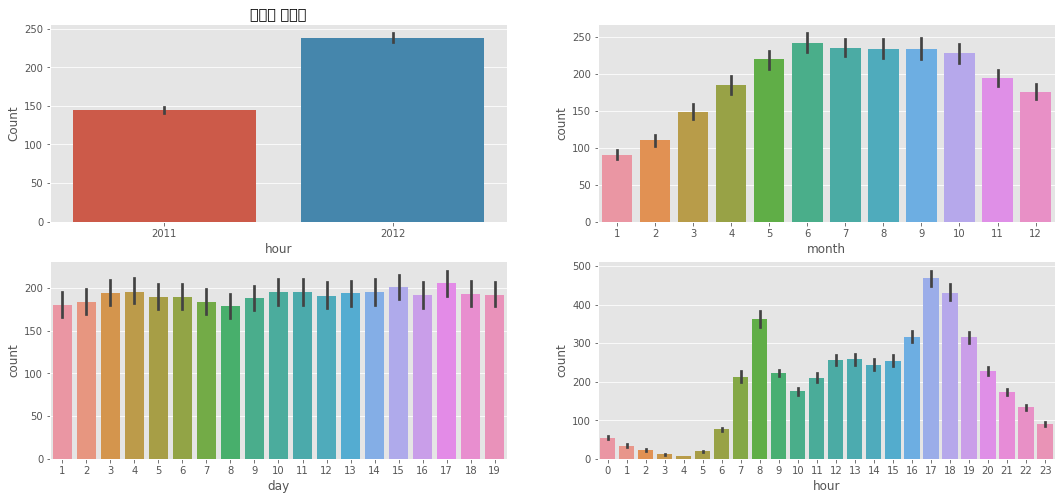

In [10]:
# 아래 코드에서 자꾸 오류가 나서 위의 셀을 추가하였음 ★

figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(18, 8)

sns.barplot(data=train, x='year', y='count', ax=ax1)
sns.barplot(data=train, x='month', y='count', ax=ax2)
sns.barplot(data=train, x='day', y='count', ax=ax3)
sns.barplot(data=train, x='hour', y='count', ax=ax4)

ax1.set(ylabel='Count', title="연도별 대여량")
ax1.set(xlabel='month', title="월별 대여량")
ax1.set(xlabel='day', title="일별 대여량")
ax1.set(xlabel='hour', title="시간별 대여량")
plt.show()

다음과 같이 시각화해보면 2011년보다 2012년에 대여량이 더 많은 것을 확인할 수 있다.\
월별데이터를 보면 겨울보다는 여름-가을 시즌에서 대여량이 높아지는 것을 확인할 수 있고,\
일별 데이터는 1-19일까지가 train data, 나머지가 test data로 분류되어 분석하는 것이 부적절하다.\
마지막으로 시간별 대여량은 출근시간인 7-9시 정도와 퇴근시간인 17~18시에서 대여량이 가장 높아지는것을 확인할 수 있다.

우리는 자전거 대여목적이 평일과 주말이 다르다고 추론할 수 있다. 그렇다면 주말과 평일에 어떻게 차이가 나는지 확인해보자

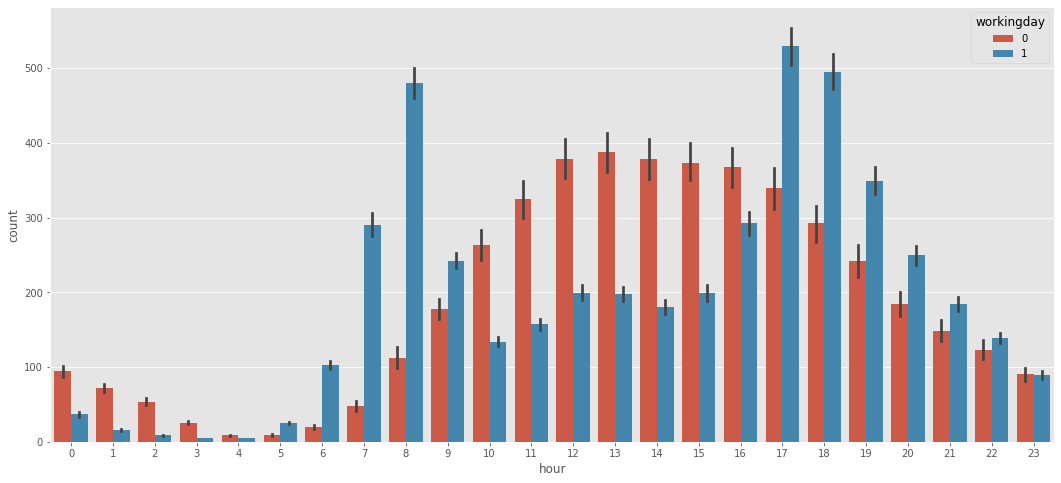

In [6]:
fig, (ax1) = plt.subplots(nrows=1)
fig.set_size_inches(18, 8)

sns.barplot(data=train, x='hour', y='count', hue='workingday', ax=ax1)
plt.show()

빨간색 그래프가 주말 데이터이고 파란색 그래프가 평일 데이터이다. 주말에는 오후 시간대에 자전거 대여량이 높은 것을 확인할 수 있고 앞의 추론이 어느 정도 타당하다고 볼 수 있다.

다음으로 여러 변수들이 어떤 관계를 가지는지 heatmap으로 나타내보자.

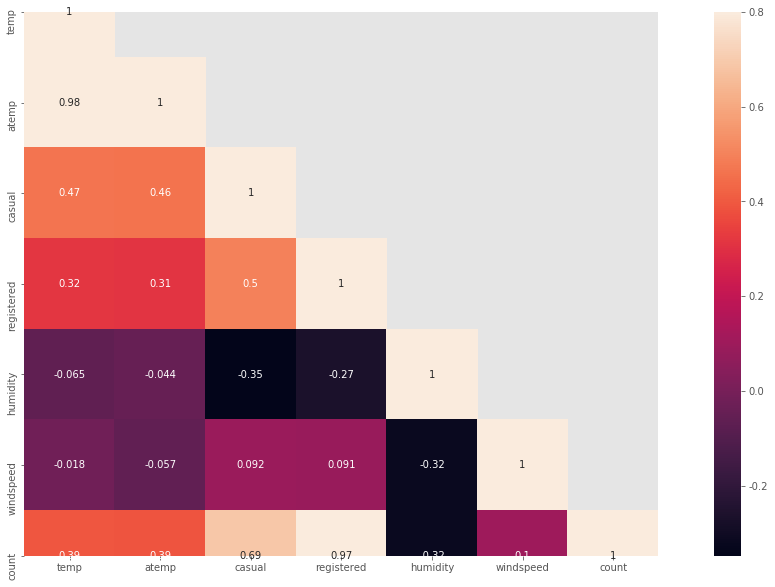

In [7]:
corrmatt = train[['temp', 'atemp', 'casual', 'registered', 'humidity', 'windspeed', 'count']]
corrmatt = corrmatt.corr()

mask = np.array(corrmatt)
mask[np.tril_indices_from(mask)] = False

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
sns.heatmap(corrmatt, mask=mask, vmax=.8, square=True, annot=True)
plt.show()

결과를 확인해보면 온도, 습도, 풍속은 거의 대여량과 상관관계가 없는 것을 확인할 수 있다.\
가장 상관관계가 높은 것은 등록자 수로 0.97의 상관관계를 가지는 것을 볼 수 있다.

다음으로 극값들을 제거하여 어느 정도 데이터를 정제해보자. ★

In [8]:
trainWithoutOutliers = train[np.abs(train['count'] - train['count'].mean()) <= (3*train['count'])]
print(train.shape)
print(trainWithoutOutliers.shape)

(10886, 16)
(8001, 16)


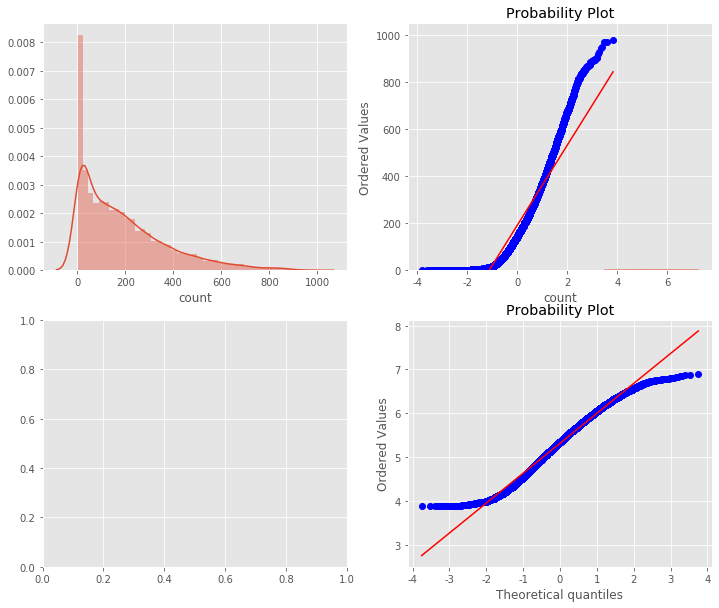

In [9]:
figure, axes = plt.subplots(ncols=2, nrows=2)
figure.set_size_inches(12, 10)

sns.distplot(train['count'], ax=axes[0][0])
stats.probplot(train['count'], dist='norm', fit=True, plot=axes[0][1])
sns.distplot(np.log(trainWithoutOutliers['count']), ax=axes[0][1])
stats.probplot(np.log1p(trainWithoutOutliers['count']), dist='norm', fit=True, plot=axes[1][1])

plt.show()

결과를 확인해보면 10000개 정도에서 2000개 정도 제거한 것을 확인할 수 있고 그래프를 보면 0값이 지나치게 높은 데이터들이 제거된 것을 확인할 수 있다.

그러면 RandomForest를 이용하여 예측해보자. ★

이후 머신러닝의 내용은 추후에 다시 따라해볼 것

The code I used above is from here. https://blog.naver.com/alstjddl8/221709935958